# Chapter 2: Multiple Hypothesis Testing

## Setup

First, we import the modules necessary for this first project. Also, we install the module `multiply` package [Puolivali et all, (2020)](#Reference)
 that contains several functions for computing the error rates based on FWER and FDR strategies.

Finally, we create crete two plot functions for plotting roc curves (`roc_curve`) and auxiliar colorbar plot for plotting the image representation of the p-values (`shiftedColorMap`)

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

import pandas as pd
import numpy as np
from scipy import stats   #ttest

# ROC metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import balanced_accuracy_score 

# Plotting figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm



In [ ]:
# Installing multipy 
!pip install -q multipy

## Plot Functions

1. `plot_roc`
2. `shiftedColorMap`

In [ ]:
## 1) Plot ROC Curves

def plot_roc(labels, predictions, title, **kwargs):
  fp, tp, _ = roc_curve(labels, predictions)
  auc_val = auc(fp, tp)
  plt.plot(fp, tp, linewidth=2, label = 'AUROC  = {:.3f}'.format(auc_val),**kwargs)
  plt.plot([0, 1], [0, 1], 'k--',label='baseline', color='grey')
  plt.xlabel('False positive rate (FPR)')
  plt.ylabel('True positive rate (TPR)')
  plt.title(title)
  plt.legend(fontsize=12)
  ax = plt.gca()
  ax.set_aspect('equal')

In [ ]:
## 1) The final image will be on scale 0 and 1. However, sometimes it is difficult
## to recognize patterns. The following function shifted the initial point in the scale of the plot
## Important: The shift is only on the plot, not in the real values:
## Source: https://stackoverflow.com/questions/40302485/matplotlib-imshow-speed-up-colour-change-in-certain-value-ranges

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    function taken from
    https://stackoverflow.com/questions/7404116/...
        ...defining-the-midpoint-of-a-colormap-in-matplotlib
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower ofset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax/(vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highets point in the colormap's range.
          Defaults to 1.0 (no upper ofset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {  'red': [],  'green': [], 'blue': [],  'alpha': []  }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = mpl.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

## Female Mice Population

The following chunks allow downloading the dataset, produce a summary of the dataset, and plotting a histogram of the control mice population.

In [ ]:
# Download the mice population. We save the weights into data frame called df
url = "https://raw.githubusercontent.com/genomicsclass/dagdata/master/inst/extdata/femaleControlsPopulation.csv"
df = pd.read_csv(url)

# Summary of the dataset
pd.options.display.float_format = "{:.2f}".format 
df.describe()

,Bodyweight
count,225.00
mean,23.89
std,3.42
min,15.51
25%,21.51
50%,23.54
75%,26.08
max,36.84


In [ ]:
# Converting the data frame into numpy array (flatten converts from 2d (column matrix) to 1d array)
population = df.to_numpy().flatten()
population.shape

(225,)

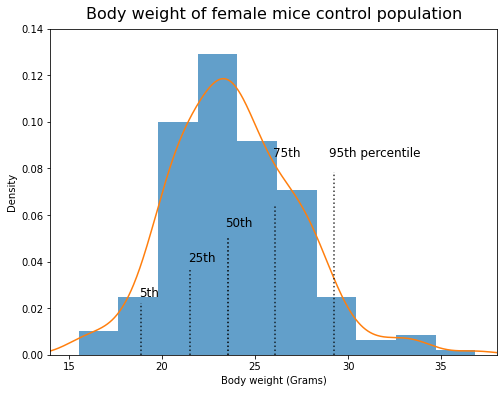

In [ ]:
Bodyweight = df["Bodyweight"]
fig, ax = plt.subplots(figsize = (8,6))

# Plot
    # Plot histogram
Bodyweight.plot(kind = "hist", density = True, alpha = 0.7) # change density to true, because KDE uses density
    # Plot KDE
Bodyweight.plot(kind = "kde")

    # Quantile lines
quant_5, quant_25, quant_50, quant_75, quant_95 = Bodyweight.quantile(0.05), Bodyweight.quantile(0.25), Bodyweight.quantile(0.5), Bodyweight.quantile(0.75), Bodyweight.quantile(0.95)
quants = [[quant_5, 0.8, 0.16], [quant_25, 0.8, 0.26], [quant_50, 1, 0.36],  [quant_75, 0.8, 0.46], [quant_95, 0.8, 0.56]]
for i in quants:
    ax.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":", color = "black")


# X
ax.set_xlabel("Body weight (Grams)")
    # Limit x range to 0-4
x_start, x_end = 14, 38
ax.set_xlim(x_start, x_end)

# Y
ax.set_ylim(0, 0.14)
#ax.set_yticklabels([])
ax.set_ylabel("Density")

# Annotations
ax.text(quant_5-.13, 0.025, "5th", size = 12, alpha = 1)
ax.text(quant_25-.13, 0.04, "25th", size = 12, alpha = 1)
ax.text(quant_50-.13, 0.055, "50th", size = 12, alpha = 1)
ax.text(quant_75-.13, 0.085, "75th", size = 12, alpha = 1)
ax.text(quant_95-.25, 0.085, "95th percentile", size = 12, alpha =1)

# Overall
#ax.grid(False)
ax.set_title("Body weight of female mice control population", size = 16, pad = 10)

    # Remove ticks and spines
#ax.tick_params(left = False, bottom = False)
#for ax, spine in ax.spines.items():
#    spine.set_visible(False)
    
plt.show()
fig.savefig("fig2_1_femaleControlPopulation.png")

In [ ]:
# We will use the propulation for sample the control mice. For example, we will sample 12 units using random.choice
np.random.seed(42)
np.random.choice(population, size= 12, replace=True)

array([26.07, 24.82, 20.69, 20.6 , 24.49, 21.65, 27.26, 20.72, 26.07,
       23.51, 24.21, 25.12])

## Classical Hypothesis Testing

We review the main ideas associated with classical hypothesis testing, especially the power of a test

### Statistical Power

Power is the probability of rejecting the null hypothesis when $H_0$ is false. We will approximate this probability using simulations. We create the function:

* `reject`

that computes the proportion of times the null hypothesis is rejected.

In [ ]:
def reject(N, B = 20, alpha = 0.05, delta = 3, seed = 42):
  '''
  MC simulation of the mean rejections for defined significance level and ES. 


  '''
  # Sample control and treatment
  np.random.seed(seed)
  controls   = np.random.choice(population, size = B*N, replace=True).reshape((B,N))
  treatments = np.random.choice(population, size = B*N, replace=True).reshape((B,N))
  treatments = treatments + delta
  p_values = np.array([result[1] for result in list(map(stats.ttest_ind, controls, treatments))])
  reject =  p_values < alpha
  return np.mean(reject)

For the range of sample units from 3 to 51, we run the `reject` function $B=2000$ times.

In [ ]:
Ns = np.arange(3,52,3)
_B = 2000
print('Number of observations: ',Ns)

power1_05 = [reject(_n, B= _B, delta = 1) for _n in Ns]
power2_05 = [reject(_n, B= _B, delta = 2) for _n in Ns]
power3_05 = [reject(_n, B= _B, delta = 3) for _n in Ns]
power4_05 = [reject(_n, B= _B, delta = 4) for _n in Ns]

power1_01 = [reject(_n, B= _B, alpha = 0.01, delta = 1) for _n in Ns]
power2_01 = [reject(_n, B= _B, alpha = 0.01, delta = 2) for _n in Ns]
power3_01 = [reject(_n, B= _B, alpha = 0.01, delta = 3) for _n in Ns]
power4_01 = [reject(_n, B= _B, alpha = 0.01, delta = 4) for _n in Ns]

Number of observations:  [ 3  6  9 12 15 18 21 24 27 30 33 36 39 42 45 48 51]


We plot the statistical power in function of the number of observations, and fixing the Effect size (ES) and significance level.

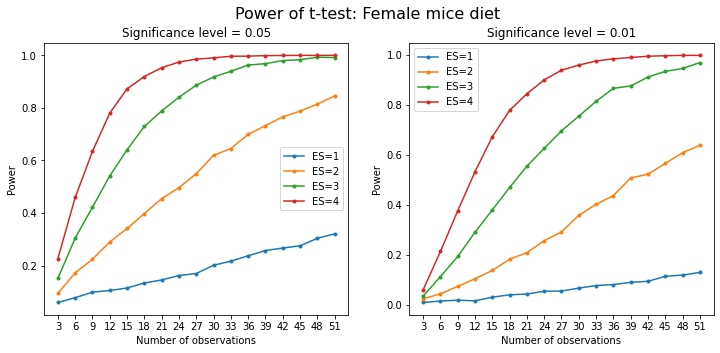

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

ax1.plot(Ns, power1_05, marker='.', label='ES=1')
ax1.plot(Ns, power2_05, marker='.', label='ES=2')
ax1.plot(Ns, power3_05, marker='.', label='ES=3')
ax1.plot(Ns, power4_05, marker='.', label='ES=4')
ax1.set_title('Significance level = 0.05')
ax1.set(xlabel='Number of observations', ylabel='Power')
ax1.set_xticks(Ns) 
ax1.legend()

ax2.plot(Ns, power1_01, marker='.', label='ES=1')
ax2.plot(Ns, power2_01, marker='.', label='ES=2')
ax2.plot(Ns, power3_01, marker='.', label='ES=3')
ax2.plot(Ns, power4_01, marker='.', label='ES=4')
ax2.set_title('Significance level = 0.01')
ax2.set(xlabel='Number of observations', ylabel='Power')
ax2.set_xticks(Ns) 
ax2.legend()

fig.suptitle('Power of t-test: Female mice diet', fontsize=16)
fig.show()
fig.savefig("fig2_2_powerFemaleFaddiet.png")

### Cohen's d Effect size index

We create two functions:

1. `cohend`: Computes the cohen'd index for two independent populations.
2. `cohend_eval`: Compute the cohen'd index for the female mice diet control and treatment

In [ ]:
# function to calculate Cohen's d for independent samples
def cohend(d1, d2):
	# calculate the size of samples
	n1, n2 = d1.shape[1], d2.shape[1]
	# calculate the variance of the samples
	s1, s2 = np.var(d1, ddof=1, axis=1), np.var(d2, ddof=1,axis=1)
	# calculate the pooled standard deviation
	s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
	# calculate the means of the samples
	u1, u2 = np.mean(d1, axis=1), np.mean(d2, axis=1)
	# calculate the effect size
	return np.abs(u1 - u2) / s

# -------------------------------------------------------------------
def cohend_eval(N = 12, B = 2000, delta = 3, alpha = 0.05, seed = 42):
  # Sample
  np.random.seed(seed)
  controls   = np.random.choice(population, size = B*N, replace=True).reshape((B,N))
  treatments = np.random.choice(population, size = B*N, replace=True).reshape((B,N))
  treatments = treatments + delta
  d = cohend(controls, treatments)
  return d

In [ ]:
d_1 = cohend_eval(N = 12, B = _B, delta = 1, alpha = 0.05)
d_2 = cohend_eval(N = 12, B = _B, delta = 2, alpha = 0.05)
d_3 = cohend_eval(N = 12, B = _B, delta = 3, alpha = 0.05)
d_4 = cohend_eval(N = 12, B = _B, delta = 4, alpha = 0.05)
data = {'ES = 1 gr': [np.mean(d_1), np.median(d_1)], 
        'ES = 2 gr': [np.mean(d_2), np.median(d_2)],
        'ES = 3 gr': [np.mean(d_3), np.median(d_3)],
        'ES = 4 gr': [np.mean(d_4), np.median(d_4)]}
 
        
df_d = pd.DataFrame.from_dict(data, orient='index', columns=['Mean', 'Median']).round(3)
df_d

,Mean,Median
ES = 1 gr,0.42,0.36
ES = 2 gr,0.63,0.60
ES = 3 gr,0.91,0.89
ES = 4 gr,1.21,1.20


We plot the Effect size of the difference of grams of 1,2,3 and 4 grams. We compute the median as the Cohens 'd Index.

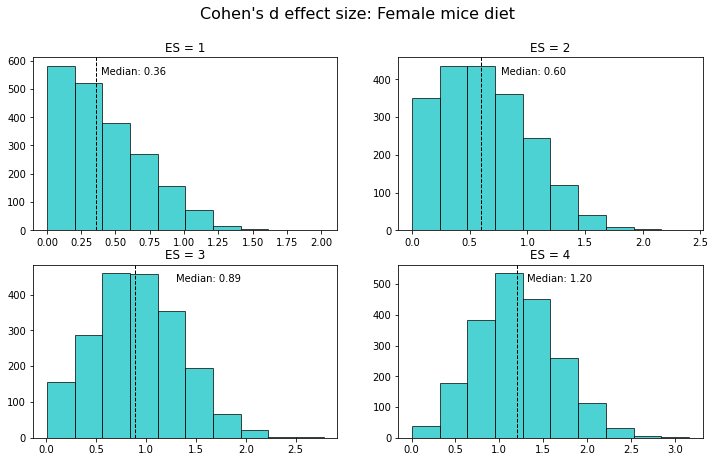

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,7))
# 0
axs[0, 0].hist(d_1, alpha=0.7 , color='c', edgecolor='k')
axs[0, 0].axvline(np.median(d_1), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = axs[0, 0].set_ylim()
axs[0, 0].text(np.median(d_1)*1.1, max_ylim*0.9, 'Median: {:.2f}'.format(np.median(d_1)))
axs[0, 0].set_title('ES = 1')

# 1
axs[0, 1].hist(d_2, alpha=0.7 , color='c', edgecolor='k')
axs[0, 1].axvline(np.median(d_2), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = axs[0, 1].set_ylim()
axs[0, 1].text(np.median(d_2)*1.3, max_ylim*0.9, 'Median: {:.2f}'.format(np.median(d_2)))
axs[0, 1].set_title('ES = 2')

# 2
axs[1, 0].hist(d_3, alpha=0.7 , color='c', edgecolor='k')
axs[1, 0].axvline(np.median(d_3), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = axs[1, 0].set_ylim()
axs[1, 0].text(1.3, max_ylim*0.9, 'Median: {:.2f}'.format(np.median(d_3)))
axs[1, 0].set_title('ES = 3')

# 3
axs[1, 1].hist(d_4, alpha=0.7 , color='c', edgecolor='k')
axs[1, 1].axvline(np.median(d_4), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = axs[1, 1].set_ylim()
axs[1, 1].text(np.median(d_4)*1.1, max_ylim*0.9, 'Median: {:.2f}'.format(np.median(d_4)))
axs[1, 1].set_title('ES = 4')

fig.suptitle('Cohen\'s d effect size: Female mice diet', fontsize=16)
fig.show()
fig.savefig("fig2_3_cohend.png")

## Hypothesis Testing on high-dimensional data 

We will consider a simulation in which we perform tests for $m = 1.000$ fad diets, of which 10% affect weight. Then, we consider the following hypothesis test: 

* $H_0$: Fad diet does not affect weight.
* $H_1$: Fad diet affects weight.

For the units whose null hypothesis is false, the effect size over the weight has an average of $\Delta = 3$ pounds. For each test, we will use a sample size of $N = 12$ from the population.

Finally, the level of significance will be set to $\alpha = 0.05$.

The goal will be to detect as many false null hypotheses as possible. To sum up, the null hypothesis is true for $m_0 = 900$ fad diets, corresponding to a proportion of true null hypothesis of $p_0 = \frac{m_0}{m} = 0.9$. The null hypothesis is false for $m_1 = 100$ features.

In [ ]:
# Simulation parameters

alpha = 0.05         # Significance level
N = 12               # Sample size
m = 1000             # Number of test
p0 = 0.90            # 10% of diets work, 90% don't
m0 = np.int16(m*p0)  # Number of test where null hypothesis is true (saved like int)
m1 = np.int16(m-m0)  # Number of test where null hypothesis is false (saved like int)
delta = 3            # Average effect size

# Ground truth
nullHypothesis = np.append(np.ones(m0, dtype=bool),np.zeros(m1, dtype=bool) )

# Number of test null hypothesis is true/false
print(m0)
print(m1)

900
100


In [ ]:
# Boolean vector of Null Hypothesis setting 
unique, counts = np.unique(nullHypothesis, return_counts=True)
pd.DataFrame.from_dict(dict(zip(unique, counts)), orient='index', columns=['Null hypothesis is:'])

,Null hypothesis is:
False,100
True,900


In [ ]:
# Monte Carlo Simulation. We sample individuals with dimensions 10.000 X 12
np.random.seed(42)
controls   = np.random.choice(population, size = N*m, replace=True).reshape((m,N))
treatments = np.random.choice(population, size = N*m, replace=True).reshape((m,N))
print('Control population shape:   ', controls.shape)
print('Treatment population shape: ', treatments.shape)

Control population shape:    (1000, 12)
Treatment population shape:  (1000, 12)


In [ ]:
# We modify the sample of treatments for the individuals whose hypothesis null is false
treatments

array([[25.08, 29.23, 24.49, ..., 19.87, 20.53, 20.25],
       [23.18, 26.85, 21.35, ..., 16.05, 22.95, 20.74],
       [20.99, 27.7 , 19.79, ..., 26.75, 18.8 , 36.84],
       ...,
       [26.14, 18.8 , 23.61, ..., 23.54, 25.14, 29.13],
       [24.8 , 21.32, 19.88, ..., 26.25, 20.81, 26.14],
       [25.54, 19.44, 31.83, ..., 22.72, 24.6 , 24.46]])

For the treatments, add a effect size $ES = \Delta$ 

In [ ]:
# For the individuals with null hypothesis false, we add the average effect size
treatments[np.logical_not(nullHypothesis),] = treatments[np.logical_not(nullHypothesis),] + delta
treatments

array([[25.08, 29.23, 24.49, ..., 19.87, 20.53, 20.25],
       [23.18, 26.85, 21.35, ..., 16.05, 22.95, 20.74],
       [20.99, 27.7 , 19.79, ..., 26.75, 18.8 , 36.84],
       ...,
       [29.14, 21.8 , 26.61, ..., 26.54, 28.14, 32.13],
       [27.8 , 24.32, 22.88, ..., 29.25, 23.81, 29.14],
       [28.54, 22.44, 34.83, ..., 25.72, 27.6 , 27.46]])

Compute the p_values for the $m=1000$ features. Then, we order in ascendeing order the p-value. Also, we use the same order for the response.

In [ ]:
# Computing the pvalues: 
p_values = np.array([result[1] for result in list(map(stats.ttest_ind, controls, treatments))])
print(p_values.shape)

(1000,)


In [ ]:
# index of the p-values sort from small to large
asc_sort = np.argsort(p_values)

# Order the p-values and null hypothesis
p_values = p_values[asc_sort]
nullHypothesis = nullHypothesis[asc_sort]

Distribution of the p_values. Mixture of a uniform distribution $H_0$ true and values concentrated in zero for $H_1$ true.

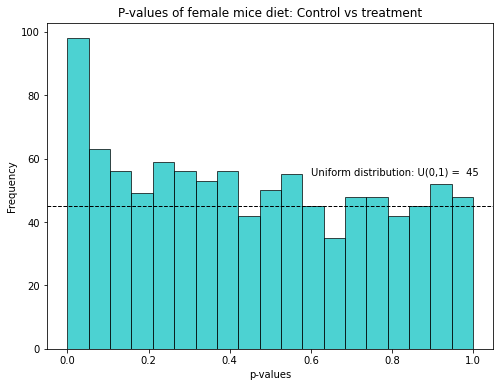

In [ ]:
# Histogram of p-values. Simulation was used to generate m1 individuals having differences.
fig, ax = plt.subplots(figsize = (8,6))
ax.hist(p_values, bins = np.linspace(0, 1, 20), alpha=0.7 , color='c', edgecolor='k')
ax.set_xlabel('p-values')
ax.set_ylabel('Frequency')
ax.axhline(m0*alpha, color='k', linestyle='dashed', linewidth=1)
ax.set_title(r'P-values of female mice diet: Control vs treatment')
ax.text(0.6, 55 , 'Uniform distribution: U(0,1) =  {:.0f}'.format(m0*alpha))

fig.show()
fig.savefig("fig2_4_pvalues.png")

### Multiple testing without correction

In [ ]:
# Total Rejections (R)
print('Total rejections (R) = ', np.sum(p_values < alpha ))

Total rejections (R) =  92


Confusion mtrix:

In [ ]:
# Declaration of significant features, given the critical value alpha
call = np.where(p_values <= alpha, False, True)

# Recode the variables:
code_nullHypothesis = np.logical_not(nullHypothesis).astype(int)
code_call = np.logical_not(call).astype(int)

# Compute Confusion matrix:
cm_call = confusion_matrix(code_nullHypothesis, code_call)

MHT_df = pd.DataFrame(cm_call, index=['True', 'False'], columns=['Not called significant', 'Significant'])
MHT_df

,Not called significant,Significant
True,860,40
False,48,52


In [ ]:
print(MHT_df.to_latex(index=True)) 

\begin{tabular}{lrr}
\toprule
{} &  Not called significant &  Significant \\
\midrule
True  &                     860 &           40 \\
False &                      48 &           52 \\
\bottomrule
\end{tabular}



Relevant statistics:

In [ ]:
# Extract the values of the Confusion matrix
TN, FP, FN, TP = cm_call.flatten()

print('False Positive (FP): V = '  + str(FP))
print('True Positive (TP):  S = '  + str(TP))
print('True Negative (TN):  U = '  + str(TN))
print('False Negative (FN): T = '  + str(FN))
print('-----------------------------')

# Type-I error rate (False Positive Rate, 1 - specificity)
FPR = FP/(FP + TN)
print('False Positive Rate (FPR) = {:.3f}'.format(FPR))

# Type-II error rate (False Negative Rate)
FNR = FN/(FN + TP)
print('False Negative Rate (FNR) = {:.3f}'.format(FNR))

# True Positive Rate (sensitivity, recall, power)
TPR = TP/(TP + FN)
print('True  Positive Rate (TPR) = {:.3f}'.format(TPR))

# Positive Predicted value: Precision
PPV = TP / (TP + FP)
print('Positive predited value (PPV) = {:.3f}'.format(PPV))

False Positive (FP): V = 40
True Positive (TP):  S = 52
True Negative (TN):  U = 860
False Negative (FN): T = 48
-----------------------------
False Positive Rate (FPR) = 0.044
False Negative Rate (FNR) = 0.480
True  Positive Rate (TPR) = 0.520
Positive predited value (PPV) = 0.565


In [ ]:
# Global Accuracy
acc = accuracy_score(code_nullHypothesis, code_call)
print('Global accuracy = {:.3f}'.format(acc))

Global accuracy = 0.912


In [ ]:
# Classification report
print(classification_report(code_nullHypothesis, code_call))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       900
           1       0.57      0.52      0.54       100

    accuracy                           0.91      1000
   macro avg       0.76      0.74      0.75      1000
weighted avg       0.91      0.91      0.91      1000



In [ ]:
# Balanced Accuracy
bal_acc = balanced_accuracy_score(code_nullHypothesis, code_call)
print('Balance accuracy = {:.3f}'.format(bal_acc))

Balance accuracy = 0.738


In [ ]:
# Area Under curve (Significance level 0.05)
auc_call = roc_auc_score(code_nullHypothesis, code_call)
print('AUC (fn: roc_auc_score) = {:.3f}'.format(auc_call))

AUC (fn: roc_auc_score) = 0.738


In [ ]:
fpr, tpr, _ = roc_curve(code_nullHypothesis, code_call)
auc_call_2 = auc(fpr, tpr)

print('FPR: ',  fpr)
print('TPR: ',  tpr)
print('----------------------------------------')
print('AUC (fn: auc) = {:.3f}'.format(auc_call_2))

FPR:  [0.         0.04444444 1.        ]
TPR:  [0.   0.52 1.  ]
----------------------------------------
AUC (fn: auc) = 0.738


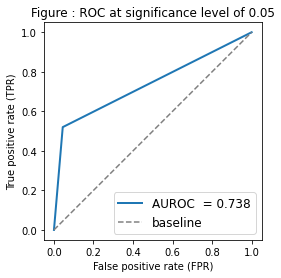

In [ ]:
# ROC Curve at especific significance level
plot_roc(code_nullHypothesis, code_call, 'Figure : ROC at significance level of 0.05')

### Error Methods

#### FWER: Bonferroni Correction

We use the function `bonferroni` from the library `multipy`. We only have two rejections under this procedure.

In [ ]:
#Import the FWER methods available in multipy
from multipy.fwer import bonferroni

# Summary multipy
significant_pvals_bonferroni = bonferroni(p_values, alpha = 0.05)
unique, counts = np.unique(significant_pvals_bonferroni, return_counts=True)
pd.DataFrame.from_dict(dict(zip(unique, counts)), orient='index', columns=['Quantity'])

,Quantity
False,998
True,2


In [ ]:
# We also can compute the report of table 1
alpha = 0.05
calls_Bonf = np.where(p_values < alpha/m, False, True)
code_call_Bonf = np.logical_not(calls_Bonf).astype(int)

cm_call_Bonf = confusion_matrix(code_nullHypothesis, code_call_Bonf)
mht_bonf = pd.DataFrame(cm_call_Bonf, index=['True', 'False'], columns=['Not called significant', 'Significant'])
mht_bonf

,Not called significant,Significant
True,900,0
False,98,2


In [ ]:
print(mht_bonf.to_latex(index=True)) 

\begin{tabular}{lrr}
\toprule
{} &  Not called significant &  Significant \\
\midrule
True  &                     900 &            0 \\
False &                      98 &            2 \\
\bottomrule
\end{tabular}



Relevant statistics:

In [ ]:
# Extract the values of the Confusion matrix
TN, FP, FN, TP = cm_call_Bonf.flatten()

print('False Positive (FP): V = '  + str(FP))
print('True Positive (TP):  S = '  + str(TP))
print('True Negative (TN):  U = '  + str(TN))
print('False Negative (FN): T = '  + str(FN))
print('-----------------------------')

# Type-I error rate (False Positive Rate, 1 - specificity)
FPR = FP/(FP + TN)
print('False Positive Rate (FPR) = {:.3f}'.format(FPR))

# Type-II error rate (False Negative Rate)
FNR = FN/(FN + TP)
print('False Negative Rate (FNR) = {:.3f}'.format(FNR))

# True Positive Rate (sensitivity, recall power)
TPR = TP/(TP + FN)
print('True  Positive Rate (TPR) = {:.3f}'.format(TPR))

# Positive Predicted value: Precision
PPV = TP / (TP + FP)
print('Positive predited value (PPV) = {:.3f}'.format(PPV))

False Positive (FP): V = 0
True Positive (TP):  S = 2
True Negative (TN):  U = 900
False Negative (FN): T = 98
-----------------------------
False Positive Rate (FPR) = 0.000
False Negative Rate (FNR) = 0.980
True  Positive Rate (TPR) = 0.020
Positive predited value (PPV) = 1.000


In [ ]:
# Global Accuracy
acc = accuracy_score(code_nullHypothesis, code_call_Bonf)
print('Global accuracy = {:.3f}'.format(acc))

Global accuracy = 0.902


In [ ]:
# Classification report
print(classification_report(code_nullHypothesis, code_call_Bonf))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95       900
           1       1.00      0.02      0.04       100

    accuracy                           0.90      1000
   macro avg       0.95      0.51      0.49      1000
weighted avg       0.91      0.90      0.86      1000



In [ ]:
# Area Under curve (Control level 0.05)
auc_call = roc_auc_score(code_nullHypothesis, code_call_Bonf)
print('AUC (fn: roc_auc_score) = {:.3f}'.format(auc_call))

AUC (fn: roc_auc_score) = 0.510


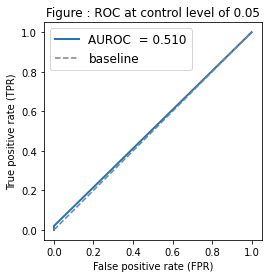

In [ ]:
# ROC curve especific control level Bonferroni
plot_roc(code_nullHypothesis, code_call_Bonf, 'Figure : ROC at control level of 0.05')

#### False Discovery Rate: Benjamini-Hochberg Correction

We use the function `lsu` of the `multipy` library. In this case, we have only 6 rejections.

In [ ]:
#Import the FDR methods (LSU corresponds to BH method)
from multipy.fdr import lsu

# BH Procedure with a control level of q = 0.05

significant_pvals_BH = lsu(p_values, q = 0.05)
unique, counts = np.unique(significant_pvals_BH, return_counts=True)
pd.DataFrame.from_dict(dict(zip(unique, counts)), orient='index', columns=['Quantity'])

,Quantity
False,994
True,6


BH bound for two control levels: $q = 0.05$ and $q = 1$. In the left panel, we make a zoom of the first 10 p-values.

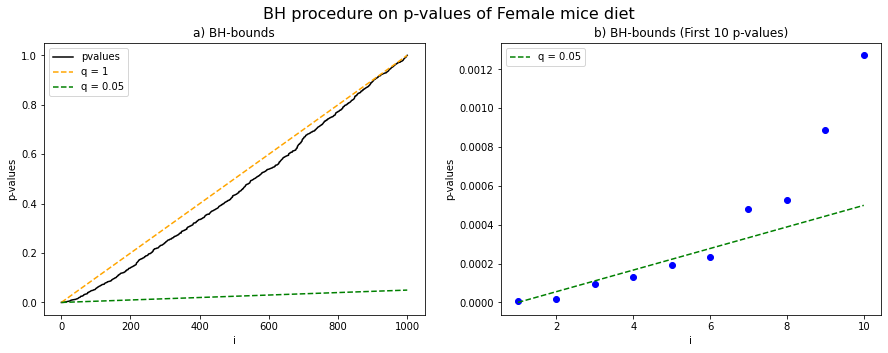

In [ ]:
# Plot the BH Bounds

i = np.arange(1,m+1)

i_10 = i[:10].copy()
p_values_10 = p_values[:10].copy()
code_nullHypothesis_10 = code_nullHypothesis[:10].copy()


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax1.plot(i, p_values, label = 'pvalues', color = 'black')
ax1.plot(np.linspace(1, m, 100), np.linspace(0, 1, 100), label = 'q = 1' ,linestyle='--', color= 'orange')
ax1.plot(np.linspace(1, m, 100), np.linspace(0, 0.05, 100), label = 'q = 0.05' ,linestyle='--', color = 'green')
ax1.set_title('a) BH-bounds')
ax1.set(xlabel='i', ylabel='p-values')
ax1.legend()

ax2.plot(i_10[code_nullHypothesis_10 > 0], p_values_10[code_nullHypothesis_10 > 0], 'bo')
ax2.plot(i_10[code_nullHypothesis_10 == 0], p_values_10[code_nullHypothesis_10 == 0], 'ro')
ax2.plot(np.linspace(1, 10, 100),
         np.linspace(0, (10/m)*0.05, 100),
         label = 'q = 0.05',
         linestyle='--',
          color = 'green')
ax2.set_title('b) BH-bounds (First 10 p-values)')
ax2.set(xlabel='i', ylabel='p-values')
ax2.legend()
fig.suptitle('BH procedure on p-values of Female mice diet', fontsize=16)
fig.show()
fig.savefig("fig2_5_BH_Bounds.png")

Confusion matrix

In [ ]:
# Complete detail of table 1
q = 0.05
BH_bound = np.arange(1,m+1)*q/m

# We also can compute the report of table 1
calls_BH = np.where(p_values <= BH_bound, False, True)
code_call_BH = np.logical_not(calls_BH).astype(int)
cm_call_BH = confusion_matrix(code_nullHypothesis, code_call_BH)
mht_BH = pd.DataFrame(cm_call_BH, index=['True', 'False'], columns=['Not called significant', 'Significant'])
mht_BH

,Not called significant,Significant
True,900,0
False,94,6


In [ ]:
print(mht_BH.to_latex(index=True)) 

\begin{tabular}{lrr}
\toprule
{} &  Not called significant &  Significant \\
\midrule
True  &                     900 &            0 \\
False &                      94 &            6 \\
\bottomrule
\end{tabular}



Relevant statistics:

In [ ]:
# Extract the values of the Confusion matrix
TN, FP, FN, TP = cm_call_BH.flatten()

print('False Positive (FP): V = '  + str(FP))
print('True Positive (TP):  S = '  + str(TP))
print('True Negative (TN):  U = '  + str(TN))
print('False Negative (FN): T = '  + str(FN))
print('-----------------------------')

# Type-I error rate (False Positive Rate, 1 - specificity)
FPR = FP/(FP + TN)
print('False Positive Rate (FPR) = {:.3f}'.format(FPR))

# Type-II error rate (False Negative Rate)
FNR = FN/(FN + TP)
print('False Negative Rate (FNR) = {:.3f}'.format(FNR))

# True Positive Rate (sensitivity, recall power)
TPR = TP/(TP + FN)
print('True  Positive Rate (TPR) = {:.3f}'.format(TPR))

# Positive Predicted value: Precision
PPV = TP / (TP + FP)
print('Positive predited value (PPV) = {:.3f}'.format(PPV))

False Positive (FP): V = 0
True Positive (TP):  S = 6
True Negative (TN):  U = 900
False Negative (FN): T = 94
-----------------------------
False Positive Rate (FPR) = 0.000
False Negative Rate (FNR) = 0.940
True  Positive Rate (TPR) = 0.060
Positive predited value (PPV) = 1.000


In [ ]:
# Global Accuracy
acc = accuracy_score(code_nullHypothesis, code_call_BH)
print('Global accuracy = {:.3f}'.format(acc))

Global accuracy = 0.906


In [ ]:
print(classification_report(code_nullHypothesis, code_call_BH))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       900
           1       1.00      0.06      0.11       100

    accuracy                           0.91      1000
   macro avg       0.95      0.53      0.53      1000
weighted avg       0.91      0.91      0.87      1000



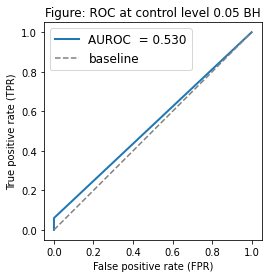

In [ ]:
plot_roc(code_nullHypothesis, code_call_BH, 'Figure: ROC at control level 0.05 BH')

## Performance metrics

We divide our analysis in thwo relevant spaces:

1. Significance space: Review of the total rejections and Type-I, Type-II error rates. The range is from 0 to 0.3 (The selection of 0.3 is based on the Lower Bound Bayes Factors that we will review next)

2. Complete space: Total rejections, ROC curva and Precision-Recall curve in the range from 0 to 1.  Given the dependency of the MHT of a threshold (significance level), the previous statitics provide a overall overview of the model.

### Significance Space: Range 0 to 0.1

We create the function:

* `MHT_Significant_values` Computes the total rejections, ROC curve, and Precision-Recall curve for the hypothesis testing without correction, Bonferroni, and BH corrections, based on the significance level.

* `MHT_Significant_values`: Summary of Total rejections, and Type-I, Type-II error rates

In [ ]:
def MHT_Significant_values(v_grid,
                           a_pvalues,
                           a_nullHypothesis,
                           n_m,
                           n_sim = 1):
  '''
  Function that computes the performance under several models:

  Input
  -----



  Output
  -----

  roc_values: FPR and TPR
  prec_recall: Precision and recall
  counts: R, fp, tp, fn, tn, type-II error  
  '''

  # Ravel the vectors of v_pvalues and v_nullHypothesis

  v_pvalues = a_pvalues.ravel()
  v_nullHypothesis = a_nullHypothesis.ravel()

  roc_values_HT = [[0,0]]
  prec_recall_HT = [[0,1]]
  counts_HT = [[0, 0, 0, np.sum(v_nullHypothesis), len(v_nullHypothesis) - np.sum(v_nullHypothesis),1]]
  
  for _alpha in v_grid:
    call = np.where(v_pvalues <= _alpha, False, True)
    code_call = np.logical_not(call).astype(int)
    tn, fp, fn, tp = confusion_matrix(v_nullHypothesis, code_call).ravel()
    R = fp + tp
    fpr = fp/(fp+tn)
    tpr = tp/(tp+fn)
    #prec = tp/(tp + fp)
    if fp == 0:
      prec = 1
    else:
      prec = tp/(tp + fp)
    # Type-II error
    fnr = fn/(fn + tp)
    roc_values_HT.append([fpr, tpr])
    prec_recall_HT.append([tpr, prec])
    counts_HT.append([R, fp, tp, fn, tn, fnr])
    # End for

  #----------------------------------------------------
  # 2) Bonferroni correction
  roc_values_Bonf = [[0,0]]
  prec_recall_Bonf = [[0,1]]
  counts_Bonf = [[0, 0, 0, np.sum(v_nullHypothesis), len(v_nullHypothesis) - np.sum(v_nullHypothesis),1]]
  for _alpha in v_grid:
    Bonf_bound = _alpha/n_m
    call = np.where(v_pvalues <= Bonf_bound, False, True)
    code_call = np.logical_not(call).astype(int)
    tn, fp, fn, tp = confusion_matrix(v_nullHypothesis, code_call).ravel()
    R = fp + tp
    fpr = fp/(fp+tn)
    tpr = tp/(tp+fn)
    #prec = tp/(tp + fp)
    if fp == 0:
      prec = 1
    else:
      prec = tp/(tp + fp)
    
    # Type-II error
    fnr = fn/(fn + tp)
    roc_values_Bonf.append([fpr, tpr])
    prec_recall_Bonf.append([tpr, prec])
    counts_Bonf.append([R, fp, tp, fn, tn, fnr])
    # End for

  #----------------------------------------------------
  # 3) Benjamini Hocheberg FDR
  
  roc_values_BH = [[0,0]]
  prec_recall_BH = [[0,1]]
  counts_BH = [[0,0,0,np.sum(v_nullHypothesis),len(v_nullHypothesis) - np.sum(v_nullHypothesis),1]]
  for _q in v_grid:
    BH_bound = np.arange(1,n_m+1)*(_q)/n_m
    BH_bound = np.tile(BH_bound,n_sim)
    call_BH_q = np.where(v_pvalues < BH_bound, False, True)
    code_call_BH_q = np.logical_not(call_BH_q).astype(int)
    tn, fp, fn, tp = confusion_matrix(v_nullHypothesis, code_call_BH_q).ravel()
    R = fp + tp
    fpr = fp/(fp + tn)
    tpr = tp/(tp+fn)
    if fp == 0:
      prec = 1
    else:
      prec = tp/(tp + fp)
    
    # Type-II error
    fnr = fn/(fn + tp)
    roc_values_BH.append([fpr, tpr])
    prec_recall_BH.append([tpr, prec])
    counts_BH.append([R, fp, tp, fn, tn, fnr])
    # End for

  # Outout_dict
  output_dict = {'roc_values_HT': roc_values_HT, 'prec_recall_HT': prec_recall_HT, 'counts_HT' : counts_HT,
                 'roc_values_Bonf': roc_values_Bonf, 'prec_recall_Bonf': prec_recall_Bonf, 'counts_Bonf' : counts_Bonf,
                 'roc_values_BH': roc_values_BH, 'prec_recall_BH': prec_recall_BH, 'counts_BH' : counts_BH}

  return output_dict

In [ ]:
def significance_report(out_trad,
                        out_ANN = None,
                        out_CNN = None):
  
  # 1) HT: Uncorrected method
  rej_HT, fp_HT, tp_HT, fn_HT,_, fnr_HT = zip(*out_trad['counts_HT'])
  fpr_HT, _ = zip(*out_trad['roc_values_HT'])

  # 2) Bonferroni
  rej_Bonf, fp_Bonf, tp_Bonf, fn_Bonf,_, fnr_Bonf = zip(*out_trad['counts_Bonf'])
  fpr_Bonf, _ = zip(*out_trad['roc_values_Bonf'])

  # 3) Benjamini Hocheberg FDR
  rej_BH, fp_BH, tp_BH, fn_BH,_, fnr_BH = zip(*out_trad['counts_BH'])
  fpr_BH, _ = zip(*out_trad['roc_values_BH'])

  if (out_ANN is not None and out_CNN is not None):
    # ANN results
    rej_ANN, fp_ANN, tp_ANN, fn_ANN,_, fnr_ANN = zip(*out_ANN['counts_DL'])
    fpr_ANN, _ = zip(*out_ANN['roc_values_DL'])
	
	  # CNN results
    rej_CNN, fp_CNN, tp_CNN, fn_CNN,_, fnr_CNN = zip(*out_CNN['counts_DL'])
    fpr_CNN, _ = zip(*out_CNN['roc_values_DL'])

    data_rejections   = {'Uncorrected': rej_HT, 'Bonferroni': rej_Bonf, 'BH': rej_BH, 'ANN' : rej_ANN, 'CNN' : rej_CNN}
    data_typeI_error  = {'Uncorrected': fpr_HT, 'Bonferroni': fpr_Bonf, 'BH': fpr_BH, 'ANN' : fpr_ANN, 'CNN' : fpr_CNN}
    data_typeII_error = {'Uncorrected': fnr_HT, 'Bonferroni': fnr_Bonf, 'BH': fnr_BH, 'ANN' : fnr_ANN, 'CNN' : fnr_CNN}
  
  elif(out_ANN is not None and out_CNN is None):
    # ANN results
    rej_ANN, fp_ANN, tp_ANN, fn_ANN,_, fnr_ANN = zip(*out_ANN['counts_DL'])
    fpr_ANN, _ = zip(*out_ANN['roc_values_DL'])

    data_rejections   = {'Uncorrected': rej_HT, 'Bonferroni': rej_Bonf, 'BH': rej_BH, 'ANN' : rej_ANN}
    data_typeI_error  = {'Uncorrected': fpr_HT, 'Bonferroni': fpr_Bonf, 'BH': fpr_BH, 'ANN' : fpr_ANN}
    data_typeII_error = {'Uncorrected': fnr_HT, 'Bonferroni': fnr_Bonf, 'BH': fnr_BH, 'ANN' : fnr_ANN}
  
  elif(out_ANN is None and out_CNN is not None):
    # CNN results
    rej_CNN, fp_CNN, tp_CNN, fn_CNN,_, fnr_CNN = zip(*out_CNN['counts_DL'])
    fpr_CNN, _ = zip(*out_CNN['roc_values_DL'])
    
    data_rejections   = {'Uncorrected': rej_HT, 'Bonferroni': rej_Bonf, 'BH': rej_BH, 'CNN' : rej_CNN}
    data_typeI_error  = {'Uncorrected': fpr_HT, 'Bonferroni': fpr_Bonf, 'BH': fpr_BH, 'CNN' : fpr_CNN}
    data_typeII_error = {'Uncorrected': fnr_HT, 'Bonferroni': fnr_Bonf, 'BH': fnr_BH, 'CNN' : fnr_CNN}
  else:
    data_rejections   = {'Uncorrected': rej_HT, 'Bonferroni': rej_Bonf, 'BH': rej_BH}
    data_typeI_error  = {'Uncorrected': fpr_HT, 'Bonferroni': fpr_Bonf, 'BH': fpr_BH}
    data_typeII_error = {'Uncorrected': fnr_HT, 'Bonferroni': fnr_Bonf, 'BH': fnr_BH}
	
  out_dict = {'data_rejections': data_rejections,
              'data_typeI_error': data_typeI_error,
              'data_typeII_error': data_typeII_error}
              
  return out_dict

Significant grid

In [ ]:
# Compute the metrics manually using the grid:
grid_significant = np.array([0.0001, 0.001, 0.005, 0.01, 0.025, 0.05, 0.1,0.2,0.3])
print('Significance levels :', grid_significant)

Significance levels : [1.0e-04 1.0e-03 5.0e-03 1.0e-02 2.5e-02 5.0e-02 1.0e-01 2.0e-01 3.0e-01]


In [ ]:
out_stats_MHT = MHT_Significant_values(v_grid = grid_significant,
                                       a_pvalues = p_values,
                                       a_nullHypothesis = code_nullHypothesis,
                                       n_m = m)

In [ ]:
MHT_sig_report = significance_report(out_trad = out_stats_MHT)

# Total Rejections:
pd.options.display.float_format = "{:.4f}".format                                     
pd_MHT_sig_report = pd.DataFrame.from_dict(MHT_sig_report['data_rejections'], orient='index', columns= np.append(0,grid_significant))
pd_MHT_sig_report

,0.0000,0.0001,0.0010,0.0050,0.0100,0.0250,0.0500,0.1000,0.2000,0.3000
Uncorrected,0,3,9,23,30,56,92,156,259,363
Bonferroni,0,0,0,0,1,2,2,3,5,6
BH,0,0,0,0,2,2,6,9,16,30


In [ ]:
print(pd_MHT_sig_report.to_latex(index=True)) 

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  0.0000 &  0.0001 &  0.0010 &  0.0050 &  0.0100 &  0.0250 &  0.0500 &  0.1000 &  0.2000 &  0.3000 \\
\midrule
Uncorrected &       0 &       3 &       9 &      23 &      30 &      56 &      92 &     156 &     259 &     363 \\
Bonferroni  &       0 &       0 &       0 &       0 &       1 &       2 &       2 &       3 &       5 &       6 \\
BH          &       0 &       0 &       0 &       0 &       2 &       2 &       6 &       9 &      16 &      30 \\
\bottomrule
\end{tabular}



In [ ]:
# Type-I errors
pd.options.display.float_format = "{:.2f}".format
pd_TypeI = pd.DataFrame.from_dict(MHT_sig_report['data_typeI_error'], orient='index', columns= np.append(0,grid_significant))
pd_TypeI

,0.00,0.00,0.00,0.01,0.01,0.03,0.05,0.10,0.20,0.30
Uncorrected,0,0.00,0.00,0.00,0.01,0.02,0.04,0.10,0.20,0.31
Bonferroni,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
BH,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01


In [ ]:
print(pd_TypeI.to_latex(index=True)) 

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  0.00 &  0.00 &  0.00 &  0.01 &  0.01 &  0.03 &  0.05 &  0.10 &  0.20 &  0.30 \\
\midrule
Uncorrected &     0 &  0.00 &  0.00 &  0.00 &  0.01 &  0.02 &  0.04 &  0.10 &  0.20 &  0.31 \\
Bonferroni  &     0 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 \\
BH          &     0 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.01 \\
\bottomrule
\end{tabular}



In [ ]:
# Type-II errors
pd_TypeII = pd.DataFrame.from_dict(MHT_sig_report['data_typeII_error'], orient='index', columns= np.append(0,grid_significant))
pd_TypeII

,0.00,0.00,0.00,0.01,0.01,0.03,0.05,0.10,0.20,0.30
Uncorrected,1,0.97,0.91,0.80,0.75,0.62,0.48,0.33,0.21,0.13
Bonferroni,1,1.00,1.00,1.00,0.99,0.98,0.98,0.97,0.95,0.94
BH,1,1.00,1.00,1.00,0.98,0.98,0.94,0.91,0.86,0.77


In [ ]:
print(pd_TypeII.to_latex(index=True)) 

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  0.00 &  0.00 &  0.00 &  0.01 &  0.01 &  0.03 &  0.05 &  0.10 &  0.20 &  0.30 \\
\midrule
Uncorrected &     1 &  0.97 &  0.91 &  0.80 &  0.75 &  0.62 &  0.48 &  0.33 &  0.21 &  0.13 \\
Bonferroni  &     1 &  1.00 &  1.00 &  1.00 &  0.99 &  0.98 &  0.98 &  0.97 &  0.95 &  0.94 \\
BH          &     1 &  1.00 &  1.00 &  1.00 &  0.98 &  0.98 &  0.94 &  0.91 &  0.86 &  0.77 \\
\bottomrule
\end{tabular}



### Complete space: Range 0 to 1.

We create the function:

* `plot_performance_metrics`: Plot the total rejections, ROC curve and Precision-Recall curve for a defined grid.


In [ ]:
# 1)
def plot_performance_metrics(v_grid,
                     out_sig_grid,
                     baseline_pr,
                     title = 'Figure', 
                     out_ANN = None,
                     out_CNN = None,
                     fig_save = None):

  ext_grid = np.append(0, v_grid)

  # HT Uncorrected
  rej_HT, fp_HT, tp_HT, fn_HT,_,_ = zip(*out_sig_grid['counts_HT'])
  fpr_HT, tpr_HT = zip(*out_sig_grid['roc_values_HT'])
  recall_HT, prec_HT = zip(*out_sig_grid['prec_recall_HT'])

  # Bonferroni correction
  rej_Bonf, fp_Bonf, tp_Bonf, fn_Bonf,_,_ = zip(*out_sig_grid['counts_Bonf'])
  fpr_Bonf, tpr_Bonf = zip(*out_sig_grid['roc_values_Bonf'])
  recall_Bonf, prec_Bonf = zip(*out_sig_grid['prec_recall_Bonf'])

  # BH
  rej_BH, fp_BH, tp_BH, fn_BH,_,_ = zip(*out_sig_grid['counts_BH'])
  fpr_BH, tpr_BH = zip(*out_sig_grid['roc_values_BH'])
  recall_BH, prec_BH = zip(*out_sig_grid['prec_recall_BH'])

  if out_ANN is not None:
    # ANN results
    rej_ANN, fp_ANN, tp_ANN, fn_ANN,_,_ = zip(*out_ANN['counts_DL'])
    fpr_ANN, tpr_ANN = zip(*out_ANN['roc_values_DL'])
    recall_ANN, prec_ANN = zip(*out_ANN['prec_recall_DL'])

  if out_CNN is not None:
    # CNN results
    rej_CNN, fp_CNN, tp_CNN, fn_CNN,_,_ = zip(*out_CNN['counts_DL'])
    fpr_CNN, tpr_CNN = zip(*out_CNN['roc_values_DL'])
    recall_CNN, prec_CNN = zip(*out_CNN['prec_recall_DL'])

  fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18,5))

  # Subplot Rejection
  ax1.plot(ext_grid,rej_HT,'-', color='darkviolet',label = 'Uncorrected')
  ax1.plot(ext_grid,rej_Bonf, '-', color='orange', label = 'Bonferroni')
  ax1.plot(ext_grid,rej_BH, '-', color='green' ,label = 'BH')
  if out_ANN is not None:
    ax1.plot(ext_grid,rej_ANN, '-', linewidth = 2, color='red', label = 'ANN')
  if out_CNN is not None:
    ax1.plot(ext_grid,rej_CNN, '-', linewidth = 2, color='mediumblue', label = 'CNN')
  ax1.set_title('Total Rejections')
  ax1.set(xlabel='Significant values', ylabel = 'Rejections (R)')
  ax1.legend()

  # Subplot ROC
  ax2.plot(fpr_HT,tpr_HT,'-', color='darkviolet', label = 'AUROC-UHT = {:.2f}'.format(auc(fpr_HT,tpr_HT)))
  ax2.plot(fpr_Bonf,tpr_Bonf, '-',color='orange', label = 'AUROC-Bonf = {:.2f}'.format(auc(fpr_Bonf,tpr_Bonf)))
  ax2.plot(fpr_BH,tpr_BH, '-' , color='green' , label = 'AUROC-BH = {:.2f}'.format(auc(fpr_BH,tpr_BH)))
  if out_ANN is not None:
    ax2.plot(fpr_ANN,tpr_ANN,'-', linewidth = 2, color='red', label = 'AUROC-ANN = {:.2f}'.format(auc(fpr_ANN,tpr_ANN)))
  if out_CNN is not None:
    ax2.plot(fpr_CNN,tpr_CNN,'-', linewidth = 2, color='mediumblue', label = 'AUROC-CNN = {:.2f}'.format(auc(fpr_CNN,tpr_CNN)))
  ax2.plot(np.linspace(0, 1*np.max(fpr_HT), 100),
         np.linspace(0, 1*np.max(fpr_HT), 100),
         label='baseline',
         linestyle='--',
         color = 'grey')
  ax2.set_title('ROC Curve')
  ax2.set(xlabel='False positive rate (FPR)', ylabel='True positive rate (TPR)')
  ax2.set_ylim([0, 1.05])
  ax2.legend()

  # Subplot Precision-Recall
  ax3.plot(recall_HT,prec_HT,'-', color='darkviolet', label = 'AUPRC-UHT = {:.2f}'.format(auc(recall_HT,prec_HT)))
  ax3.plot(recall_Bonf,prec_Bonf, '-',color='orange', label = 'AUPRC-Bonf = {:.2f}'.format(auc(recall_Bonf,prec_Bonf)))
  ax3.plot(recall_BH,prec_BH, '-' , color='green' , label = 'AUPRC-BH = {:.2f}'.format(auc(recall_BH,prec_BH)))
  if out_ANN is not None:
    ax3.plot(recall_ANN,prec_ANN,'-', linewidth = 2 ,color='red', label = 'AUPRC-ANN = {:.2f}'.format(auc(recall_ANN,prec_ANN)))
  if out_CNN is not None:
    ax3.plot(recall_CNN,prec_CNN,'-', linewidth = 2 ,color='mediumblue', label = 'AUPRC-CNN = {:.2f}'.format(auc(recall_CNN,prec_CNN)))
  ax3.plot([0,1], [baseline_pr,baseline_pr], linestyle='--', label = 'Baseline = {:.2f}'.format(baseline_pr), color = 'grey')
  ax3.set_title('Precision-Recall Curve')
  ax3.set(xlabel='Recall', ylabel='Precision')
  ax3.set_ylim([0, 1.05])
  ax3.legend()

  fig.suptitle(title, fontsize=16)
  fig.show()
  if fig_save is not None:
    fig.savefig(fig_save)

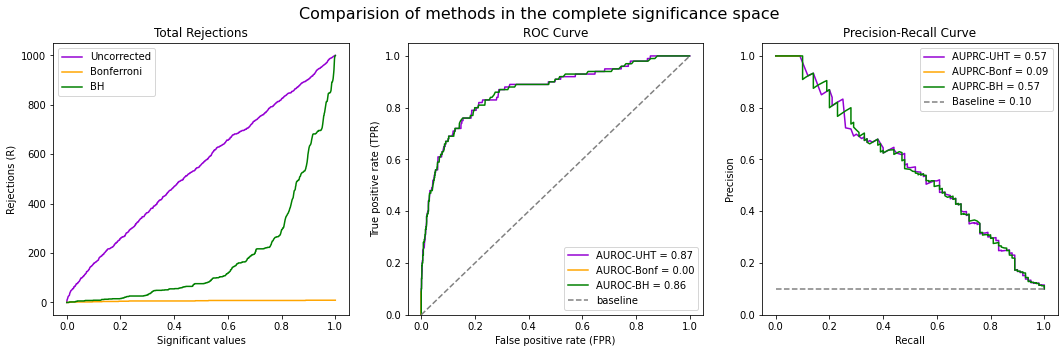

In [ ]:
# Compute the metrics manually using the grid:
grid_significant =  np.arange(0, 1.001, 0.001)


out_stats_MHT = MHT_Significant_values(v_grid = grid_significant,
                                       a_pvalues = p_values,
                                       a_nullHypothesis = code_nullHypothesis,
                                       n_m = m)

# Plot function
baseline_pr = np.sum(code_nullHypothesis.ravel())/len(code_nullHypothesis.ravel())
plot_performance_metrics(v_grid = grid_significant,
                 out_sig_grid = out_stats_MHT,
                 baseline_pr = baseline_pr,
                 title = 'Comparision of methods in the complete significance space',
                 fig_save = 'fig2_6_plot_perf_methods')

In [ ]:
total_stats = significance_report(out_trad = out_stats_MHT)

# Total Rejections:
pd.options.display.float_format = "{:.4f}".format                                     
pd_MHT_sig_report = pd.DataFrame.from_dict(total_stats['data_rejections'], orient='index', columns= np.append(0,grid_significant))
pd_MHT_sig_report

,0.0000,0.0000,0.0010,0.0020,0.0030,0.0040,0.0050,0.0060,0.0070,0.0080,0.0090,0.0100,0.0110,0.0120,0.0130,0.0140,0.0150,0.0160,0.0170,0.0180,0.0190,0.0200,0.0210,0.0220,0.0230,0.0240,0.0250,0.0260,0.0270,0.0280,0.0290,0.0300,0.0310,0.0320,0.0330,0.0340,0.0350,0.0360,0.0370,0.0380,...,0.9610,0.9620,0.9630,0.9640,0.9650,0.9660,0.9670,0.9680,0.9690,0.9700,0.9710,0.9720,0.9730,0.9740,0.9750,0.9760,0.9770,0.9780,0.9790,0.9800,0.9810,0.9820,0.9830,0.9840,0.9850,0.9860,0.9870,0.9880,0.9890,0.9900,0.9910,0.9920,0.9930,0.9940,0.9950,0.9960,0.9970,0.9980,0.9990,1.0000
Uncorrected,0,0,9,13,15,20,23,25,26,27,28,30,36,39,42,43,47,48,49,50,51,52,54,55,56,56,56,62,62,64,65,65,65,68,69,72,74,76,76,76,...,964,965,965,966,968,969,969,971,971,973,975,978,980,980,981,983,985,985,986,987,988,988,988,989,990,990,991,991,992,993,994,995,996,996,997,997,997,998,998,1000
Bonferroni,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,...,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9
BH,0,0,0,0,0,0,0,0,0,0,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,4,4,4,4,4,4,...,775,783,790,795,802,810,813,813,813,815,824,832,839,845,847,847,847,848,848,848,850,851,855,858,868,882,891,892,892,896,900,907,917,929,942,963,986,995,997,999


## Bayesian Approach of p-values

In [ ]:
sig_level = 0.05
print('Total p-values less than 0.05: ', len(p_values[p_values<sig_level]))
print('Total p-values less than 0.05 (H0 true, FP): ',len(p_values[np.logical_and(code_nullHypothesis== 0, p_values<sig_level)]))
print('Total p-values less than 0.05 (H0 false, TP): ',len(p_values[np.logical_and(code_nullHypothesis> 0, p_values<sig_level)]))

Total p-values less than 0.05:  92
Total p-values less than 0.05 (H0 false):  40
Total p-values less than 0.05 (H0 true):  52


In [ ]:
sig_level = 0.01
print('Total p-values less than 0.01: ', len(p_values[p_values<sig_level]))
print('Total p-values less than 0.01 (H0 true, FP): ',len(p_values[np.logical_and(code_nullHypothesis== 0, p_values<sig_level)]))
print('Total p-values less than 0.01 (H0 false, TP): ',len(p_values[np.logical_and(code_nullHypothesis> 0, p_values<sig_level)]))

Total p-values less than 0.01:  30
Total p-values less than 0.01 (H0 false):  5
Total p-values less than 0.01 (H0 true):  25


In [ ]:
pd.options.display.float_format = "{:.4f}".format

# P-values, Lower Bound BF and Odds of H0 to H1
#p_values_sbb = grid_significant.copy()
p_values_sbb = np.array([0.0001, 0.001, 0.005, 0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 1/np.exp(1)])
B_p = np.where(p_values_sbb < (1/np.exp(1)), -np.exp(1)*p_values_sbb*np.log(p_values_sbb), 1)
df = pd.DataFrame(np.vstack([p_values_sbb, np.around(B_p,4), np.around(1/B_p,4)]), index = ['p', 'LBBF(p)', 'Odds (H0 to H1)'])
df

,0,1,2,3,4,5,6,7,8,9
p,0.0001,0.0010,0.0050,0.0100,0.0250,0.0500,0.1000,0.2000,0.3000,0.3679
LBBF(p),0.0025,0.0188,0.0720,0.1252,0.2507,0.4072,0.6259,0.8750,0.9818,1.0000
Odds (H0 to H1),399.4200,53.2560,13.8867,7.9884,3.9891,2.4560,1.5977,1.1429,1.0185,1.0000


In [ ]:
print(df.to_latex(index=True)) 

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &        0 &       1 &       2 &      3 &      4 &      5 &      6 &      7 &      8 &      9 \\
\midrule
p               &   0.0001 &  0.0010 &  0.0050 & 0.0100 & 0.0250 & 0.0500 & 0.1000 & 0.2000 & 0.3000 & 0.3679 \\
LBBF(p)         &   0.0025 &  0.0188 &  0.0720 & 0.1252 & 0.2507 & 0.4072 & 0.6259 & 0.8750 & 0.9818 & 1.0000 \\
Odds (H0 to H1) & 399.4200 & 53.2560 & 13.8867 & 7.9884 & 3.9891 & 2.4560 & 1.5977 & 1.1429 & 1.0185 & 1.0000 \\
\bottomrule
\end{tabular}



In [ ]:
# Logic condition: p-value < 1/e  (Only 43% of the p-values is less than 1/e)

sbb_condition = p_values < (1/np.exp(1))
unique, counts = np.unique(sbb_condition, return_counts=True)
pd.DataFrame.from_dict(dict(zip(unique, counts)), orient='index', columns=['Quantity'])

,Quantity
False,566
True,434


In [ ]:
# We compute the BF lower bound. Print his shape and some of the values
lbbf = np.where(p_values < (1/np.exp(1)), -np.exp(1)*p_values*np.log(p_values), 1) # Bayes Factor Lower Bound
print(lbbf.shape)

(1000,)


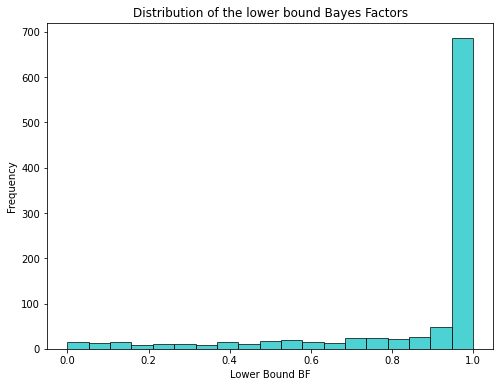

In [ ]:
fig, ax = plt.subplots(figsize = (8,6))
ax.hist(lbbf, bins = np.linspace(0, 1, 20), alpha=0.7 , color='c', edgecolor='k')
ax.set_xlabel('Lower Bound BF')
ax.set_ylabel('Frequency')
ax.set_title(r'Distribution of the lower bound Bayes Factors')

fig.show()

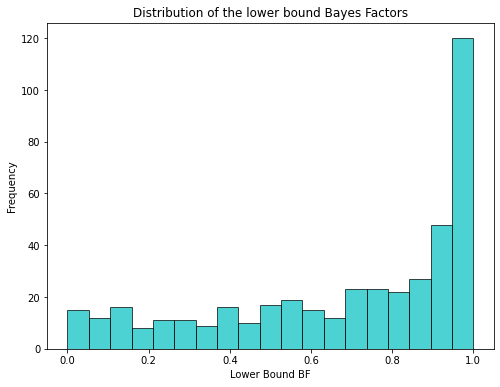

In [ ]:

fig, ax = plt.subplots(figsize = (8,6))
ax.hist(lbbf[lbbf<1], bins = np.linspace(0, 1, 20), alpha=0.7 , color='c', edgecolor='k')
ax.set_xlabel('Lower Bound BF')
ax.set_ylabel('Frequency')
ax.set_title(r'Distribution of the lower bound Bayes Factors')

fig.show()
#fig.savefig("fig1_8_lbbf.png")

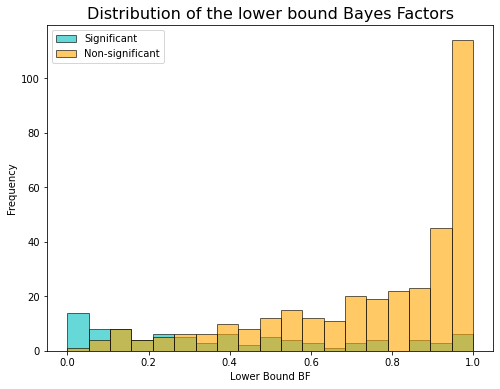

In [ ]:
fig, ax = plt.subplots(figsize = (8,6))
ax.hist(lbbf[np.logical_and(code_nullHypothesis>0, lbbf<1)], bins = np.linspace(0, 1, 20), alpha=0.6 , color='c', edgecolor='k', label = 'Significant')
ax.hist(lbbf[np.logical_and(code_nullHypothesis==0, lbbf<1)], bins = np.linspace(0, 1, 20), alpha=0.6 , color='orange', edgecolor='k', label = 'Non-significant')
ax.set_xlabel('Lower Bound BF')
ax.set_ylabel('Frequency')
ax.set_title(r'Distribution of the lower bound Bayes Factors', fontsize = 16)
ax.legend()

fig.show()
fig.savefig('fig2_7_LBBF.png')

## P-values representation: Quotient of LBBF

In [ ]:
# To compute the quotient lbf[t]/lbf, we create a lambda function
div_lbbf = lambda t: lbbf[t]/lbbf

# Then, the image is compute for each vector input using a list comprehension
image_lbbf = np.array([div_lbbf(xi) for xi in np.arange(0,m)]).T

# We compute the maximum lbf quotient, in order to standarize the matrix in the 
# range 0 and 1
max_lbbf = np.max(image_lbbf)
X = image_lbbf/max_lbbf
print('Maximum quotient = {:.3f}'.format(max_lbbf))
print('----------')
print(X)

Maximum quotient = 3287.276
----------
[[3.04203233e-04 4.93362852e-04 2.39405820e-03 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]
 [1.87569061e-04 3.04203233e-04 1.47615541e-03 ... 6.16591281e-01
  6.16591281e-01 6.16591281e-01]
 [3.86538668e-05 6.26896099e-05 3.04203233e-04 ... 1.27065930e-01
  1.27065930e-01 1.27065930e-01]
 ...
 [9.25396069e-08 1.50082575e-07 7.28280244e-07 ... 3.04203233e-04
  3.04203233e-04 3.04203233e-04]
 [9.25396069e-08 1.50082575e-07 7.28280244e-07 ... 3.04203233e-04
  3.04203233e-04 3.04203233e-04]
 [9.25396069e-08 1.50082575e-07 7.28280244e-07 ... 3.04203233e-04
  3.04203233e-04 3.04203233e-04]]


In [ ]:
# Standandarization of the image in range 0 - 1
print('Max pixel value = {:.0f}'.format(np.max(X)))
print('Min pixel value = {:.0f}'.format(np.min(X)))

Max pixel value = 1
Min pixel value = 0


In [ ]:
# Where is the maximum and the minimum
ind_max = np.unravel_index(np.argmax(image_lbbf, axis=None), image_lbbf.shape)
ind_min = np.unravel_index(np.argmin(image_lbbf, axis=None), image_lbbf.shape)
print('Max value (First Entry position):', ind_max)
print('Min value (First Entry position):', ind_min)

Max value (First Entry position): (0, 434)
Min value (First Entry position): (434, 0)


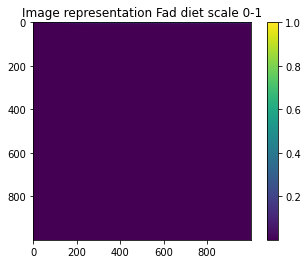

In [ ]:
plt.imshow(X)
plt.title('Image representation Fad diet scale 0-1')
plt.colorbar()
plt.show()

In [ ]:
less_02 = (np.count_nonzero(X < 0.2)/(m*m))*100
less_005 = (np.count_nonzero(X < 0.005)/(m*m))*100
less_10e = (np.count_nonzero(X < 1e-5)/(m*m))*100

print('Quotients less than 0.2 = {:.3f} %'.format(less_02))
print('Quotients less than 0.005 = {:.3f} %'.format(less_005))
print('Quotients less than 1e-5 = {:.3f} %'.format(less_10e))

Quotients less than 0.2 = 99.813 %
Quotients less than 0.005 = 98.251 %
Quotients less than 1e-5 = 1.167 %


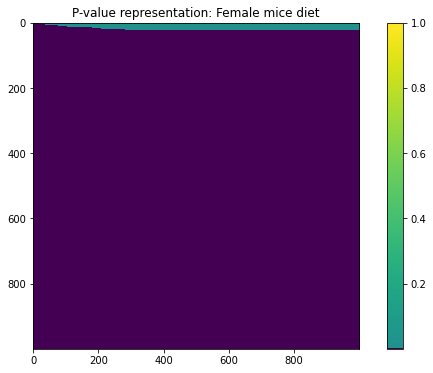

In [ ]:
# Shifted middle point
orig_cmap = mpl.cm.viridis 
shifted_cmap = shiftedColorMap(orig_cmap, midpoint=1e-12, name='shifted')
plt.figure(figsize=(10,6))
plt.imshow(X, interpolation="none", cmap=shifted_cmap)
plt.title('P-value representation: Female mice diet')
plt.colorbar()
#plt.savefig('fig1_9_p_rep1.png')
plt.show()

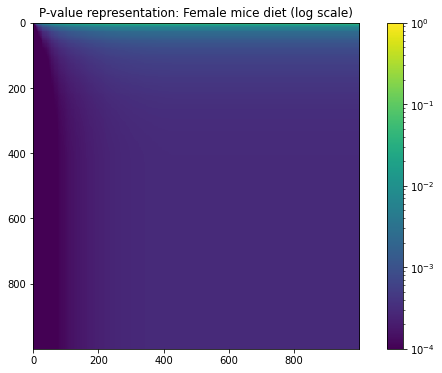

In [ ]:
# Log scale
plt.figure(figsize=(10,6))
plt.imshow(X, interpolation="none", norm= LogNorm(vmin=1e-4, vmax=1), cmap=orig_cmap)
plt.title('P-value representation: Female mice diet (log scale)')
plt.colorbar()
plt.savefig('fig1_10_p_rep1.png')
plt.show()

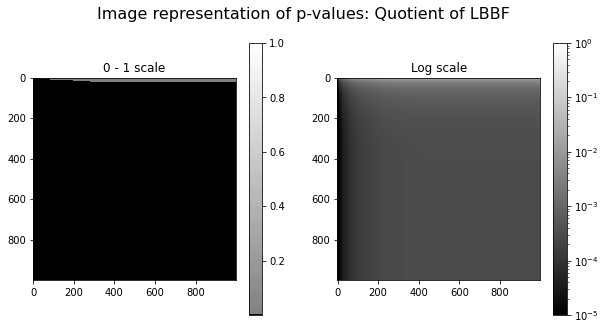

In [ ]:
# Plot ROC and Precision-Recall


orig_cmap = mpl.cm.gray 
shifted_cmap = shiftedColorMap(orig_cmap, midpoint=1e-5, name='shifted')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

im = ax[0].imshow(X, interpolation="none", cmap=shifted_cmap)
plt.colorbar(im, ax=ax[0])
ax[0].set_title('0 - 1 scale')

im = ax[1].imshow(X, norm=LogNorm(vmin=1e-5, vmax=1), cmap='gray')
plt.colorbar(im, ax=ax[1])
ax[1].set_title('Log scale')

fig.suptitle('Image representation of p-values: Quotient of LBBF', fontsize=16)
fig.show()
fig.savefig('fig2_8_img_rep.png')

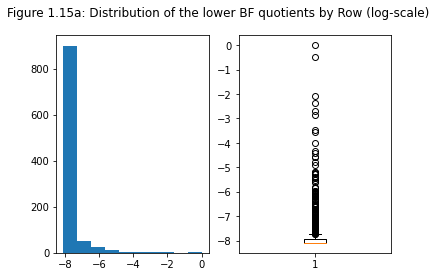

In [ ]:
# Histogram of maximum of each row (We check the maximum of each row with columns)
max_col = np.log(np.max(X, axis=1))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Figure 1.15a: Distribution of the lower BF quotients by Row (log-scale)')
ax1.hist(max_col)
ax2.boxplot(max_col)
fig.show()

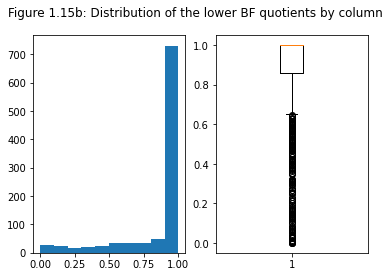

In [ ]:
# Distribution over the columns (Look for the max reviewing the columns)
max_row = np.max(X, axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Figure 1.15b: Distribution of the lower BF quotients by column')
ax1.hist(max_row)
ax2.boxplot(max_row)
fig.show()

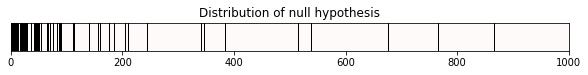

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,8))

cmap = mpl.colors.ListedColormap(['snow', 'k'])

extent = 0,1000,0,1
im = ax.imshow(code_nullHypothesis.reshape(1,1000), cmap=cmap, extent = extent)
asp = np.diff(ax.get_xlim())[0] / np.diff(ax.get_ylim())[0]
ax.set_aspect(asp*0.05)
ax.set(ylabel='')
ax.set_yticks([])
#plt.colorbar(im, ax=ax[0])
ax.set_title(r'Distribution of null hypothesis')

fig.show()
fig.savefig('fig2_9_null_H.png')

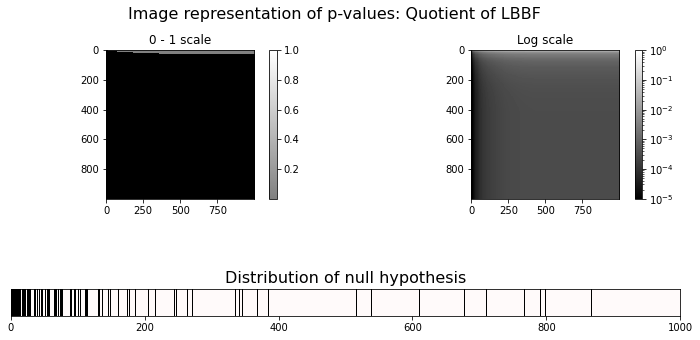

In [ ]:
# Complete problem representation

fig = plt.figure(figsize=(12, 6))
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,1,2)
axes = [ax1, ax2, ax3]

im = ax1.imshow(X, interpolation="none", cmap=shifted_cmap)
plt.colorbar(im, ax=ax1)
ax1.set_title('0 - 1 scale')

im = ax2.imshow(X, norm=LogNorm(vmin=1e-5, vmax=1), cmap='gray')
plt.colorbar(im, ax=ax2)
ax2.set_title('Log scale')


ax3.imshow(code_nullHypothesis.reshape(1,1000), cmap=cmap, extent = extent)
asp = np.diff(ax3.get_xlim())[0] / np.diff(ax3.get_ylim())[0]
ax3.set_aspect(asp*0.04)
ax3.set(ylabel='')
ax3.set_yticks([])
ax3.set_title(r'Distribution of null hypothesis', fontsize = 16)


fig.suptitle('Image representation of p-values: Quotient of LBBF', fontsize=16)
fig.show()
fig.savefig('fig2_8_img_rep.png')

In [ ]:
# Download the figures
import os
# directory
print( os.getcwd() )
print( os.listdir() )


from google.colab import files
#files.download("fig2_1_femaleControlPopulation.png")
#files.download("fig2_2_powerFemaleFaddiet.png")
#files.download("fig2_3_cohend.png")  
#files.download("fig2_4_pvalues.png")
#files.download("fig2_5_BH_Bounds.png")
files.download("fig2_6_plot_perf_methods.png")
#files.download("fig2_7_LBBF.png")
#files.download("fig2_8_img_rep.png")
#files.download("fig2_9_null_H.png")

/content
['.config', 'fig2_6_plot_perf_methods.png', 'fig2_8_img_rep.png', 'sample_data']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Application Example (Based on training in chapter 3)

In [ ]:
# Import tensorFlow / Keras
import tensorflow as tf
from tensorflow import keras

# Print the versions of TensorFlow/Keras. Version superior to 2.x are required
print('TensorFlow version:', tf.__version__)
print('Keras version:',keras.__version__)

TensorFlow version: 2.6.0
Keras version: 2.6.0


In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
# Load from google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
# directory
print( os.getcwd() )
print( os.listdir() )

/content
['.config', 'fig2_6_plot_perf_methods.png', 'gdrive', 'fig2_8_img_rep.png', 'sample_data']


In [ ]:
# Recreate the exact same model, including its weights and the optimizer
model_CNN = keras.models.load_model('/content/gdrive/MyDrive/Application_CNNs_MHT_code/my_model_MICE_CNN_m1000.h5')

# Show the model architecture
model_CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1000, 1000, 2)     20        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 500, 500, 2)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 500, 500, 4)       76        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 250, 250, 4)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 250, 250, 8)       296       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 125, 125, 8)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 125, 125, 16)      1

For reference, an ANN model will have the following number of parameters:

In [ ]:
# Define a simple sequential model
def create_ANN_model(INPUT_SHAPE,
                     OUT_CLASSES,
                     INITIALIZER,
                     NEURONS_1, NEURONS_2,
                     LOSS_FN,
                     OPTIMIZER,
                     METRICS,
                     SEED = 42):

  # 0)
  keras.backend.clear_session()

  # 1) Set seed
  np.random.seed(SEED)
  tf.random.set_seed(SEED)

  # 2) Sequential model
  model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = INPUT_SHAPE),
    keras.layers.Dense(NEURONS_1, 
                       kernel_initializer = INITIALIZER,
                       activation = "relu"),
    keras.layers.Dense(NEURONS_2, 
                       kernel_initializer = INITIALIZER,
                       activation = "relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(OUT_CLASSES, 
                       activation = "sigmoid")
  ])

  #2) compile method
  model.compile(loss      = LOSS_FN,
                optimizer = OPTIMIZER,
                metrics   = METRICS)
  
  return model


# Refresh: Number of (null) hypothesis test
print('Total Null hypothesis:', m)
print('--------------------------')

# Multilabel classification: Define the number of elements of input/output in the NN
# same as (_m)

INPUT_SHAPE_ANN  = [m, m]
OUT_CLASSES_ANN = m

# print
print('Input: Dimension image LBBF: ', INPUT_SHAPE_ANN)
print('Output: Number of labels', OUT_CLASSES_ANN)


# 2) Hyperparameters:

## 2.1) Number of neurons by (hidden) layer
NEURONS_1 = 300   # 50% of the total pixels
NEURONS_2 = 250        # 25% of the total pixels

## 2.2) Initial weight
INITIALIZER = keras.initializers.HeUniform()

# 3)  compilationHyperparameters
LOSS_FN   = keras.losses.binary_crossentropy
OPTIMIZER = keras.optimizers.Nadam()
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='AUROC'),
      keras.metrics.AUC(name='AUPRC', curve='PR'), # precision-recall curve
]

# Create the model instance
model_ANN = create_ANN_model(INPUT_SHAPE_ANN,
                     OUT_CLASSES_ANN,
                     INITIALIZER,
                     NEURONS_1, NEURONS_2,
                     LOSS_FN,
                     OPTIMIZER,
                     METRICS)

# Print Model summary (model's architecture)
model_ANN.summary()

Total Null hypothesis: 1000
--------------------------
Input: Dimension image LBBF:  [1000, 1000]
Output: Number of labels 1000
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1000000)           0         
_________________________________________________________________
dense (Dense)                (None, 300)               300000300 
_________________________________________________________________
dense_1 (Dense)              (None, 250)               75250     
_________________________________________________________________
dropout (Dropout)            (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              251000    
Total params: 300,326,550
Trainable params: 300,326,550
Non-trainable params: 0
______________________________________________

In [ ]:
# Reshape into 4D tensor
X_test = X.reshape(1,m,m,1)
print('Input shape:', X_test.shape)

# Model prediction:
y_score = model_CNN.predict(X_test)
print('Score shape:', y_score.shape)


Input shape: (1, 1000, 1000, 1)
Score shape: (1, 1000)


### Significance space

In [ ]:
def DL_Significant_values(v_grid, a_test, a_score):

  '''
  Function that computes the performance under several models:

  Input
  -----



  Output
  -----

  roc_values: FPR and TPR
  prec_recall: Precision and recall
  counts: R, fp, tp, fn, tn, type-II error  
  '''

  y_fpr, _, thresholds = roc_curve(a_test.ravel(), a_score.ravel())
   
  roc_values_DL = [[0,0]]
  prec_recall_DL = [[0,1]]
  v_nullHypothesis = a_test.ravel()
  counts_DL = [[0, 0, 0, np.sum(v_nullHypothesis),len(v_nullHypothesis) - np.sum(v_nullHypothesis), 1]]
  for tt in v_grid:

    # Create copy of the thresholds and fpr objects
    max_thr_fpr = thresholds[len(y_fpr[y_fpr <= tt]) - 1]
    y_hat = np.where(a_score >= max_thr_fpr, 1,0)
    
    tn, fp, fn, tp = confusion_matrix(v_nullHypothesis, y_hat.ravel()).ravel()
    R = fp + tp
    fpr = fp/(fp + tn)
    tpr = tp/(tp+fn)
    if fp == 0:
      prec = 1
    else:
      prec = tp/(tp + fp)
    # Type-II error
    fnr = fn/(fn + tp)
    roc_values_DL.append([fpr, tpr])
    prec_recall_DL.append([tpr, prec])
    counts_DL.append([R, fp, tp, fn, tn, fnr])
    # End for

  # Outout_dict
  output_dict = {'roc_values_DL': roc_values_DL, 'prec_recall_DL': prec_recall_DL, 'counts_DL' : counts_DL}

  return output_dict

In [ ]:
# Compute the metrics manually using the grid:
grid_significant = np.array([0.0001, 0.001, 0.005, 0.01, 0.025, 0.05, 0.1,0.2,0.3])
print('Significance levels :', grid_significant)
print('---------------------------------------')
print('Total rejections (R):')

out_stats_MHT = MHT_Significant_values(v_grid = grid_significant,
                                       a_pvalues = p_values,
                                       a_nullHypothesis = code_nullHypothesis,
                                       n_m = m)

# Performance CNN for several significant values
out_test_CNN = DL_Significant_values(v_grid = grid_significant, 
                                      a_test = code_nullHypothesis,     
                                      a_score = y_score)


comparison_sig_report = significance_report(out_trad = out_stats_MHT,
                                            out_CNN = out_test_CNN)
# Total Rejections:
pd.options.display.float_format = "{:.4f}".format                                     
pd_full_report = pd.DataFrame.from_dict(comparison_sig_report['data_rejections'], orient='index', columns= np.append(0,grid_significant))
pd_full_report

Significance levels : [1.0e-04 1.0e-03 5.0e-03 1.0e-02 2.5e-02 5.0e-02 1.0e-01 2.0e-01 3.0e-01]
---------------------------------------
Total rejections (R):


,0.0000,0.0001,0.0010,0.0050,0.0100,0.0250,0.0500,0.1000,0.2000,0.3000
Uncorrected,0,3,9,23,30,56,92,156,259,363
Bonferroni,0,0,0,0,1,2,2,3,5,6
BH,0,0,0,0,2,2,6,9,16,30
CNN,0,16,16,26,40,66,93,145,251,357


In [ ]:
print(pd_full_report.to_latex(index=True))

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  0.0000 &  0.0001 &  0.0010 &  0.0050 &  0.0100 &  0.0250 &  0.0500 &  0.1000 &  0.2000 &  0.3000 \\
\midrule
Uncorrected &       0 &       3 &       9 &      23 &      30 &      56 &      92 &     156 &     259 &     363 \\
Bonferroni  &       0 &       0 &       0 &       0 &       1 &       2 &       2 &       3 &       5 &       6 \\
BH          &       0 &       0 &       0 &       0 &       2 &       2 &       6 &       9 &      16 &      30 \\
CNN         &       0 &      12 &      12 &      27 &      36 &      61 &      98 &     151 &     248 &     349 \\
\bottomrule
\end{tabular}



In [ ]:
# Type-I errors
pd.options.display.float_format = "{:.2f}".format
pd_full_report_TypeI =  pd.DataFrame.from_dict(comparison_sig_report['data_typeI_error'], orient='index', columns= np.append(0,grid_significant))
pd_full_report_TypeI

,0.00,0.00,0.00,0.01,0.01,0.03,0.05,0.10,0.20,0.30
Uncorrected,0,0.00,0.00,0.00,0.01,0.02,0.04,0.10,0.20,0.31
Bonferroni,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
BH,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
CNN,0,0.00,0.00,0.00,0.01,0.02,0.05,0.10,0.19,0.30


In [ ]:
print(pd_full_report_TypeI.to_latex(index=True))

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  0.00 &  0.00 &  0.00 &  0.01 &  0.01 &  0.03 &  0.05 &  0.10 &  0.20 &  0.30 \\
\midrule
Uncorrected &     0 &  0.00 &  0.00 &  0.00 &  0.01 &  0.02 &  0.04 &  0.10 &  0.20 &  0.31 \\
Bonferroni  &     0 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 \\
BH          &     0 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.00 &  0.01 \\
CNN         &     0 &  0.00 &  0.00 &  0.00 &  0.01 &  0.02 &  0.05 &  0.10 &  0.19 &  0.30 \\
\bottomrule
\end{tabular}



In [ ]:
# Type-II errors
pd_full_report_TypeII = pd.DataFrame.from_dict(comparison_sig_report['data_typeII_error'], orient='index', columns= np.append(0,grid_significant))
pd_full_report_TypeII

,0.00,0.00,0.00,0.01,0.01,0.03,0.05,0.10,0.20,0.30
Uncorrected,1,0.97,0.91,0.80,0.75,0.62,0.48,0.33,0.21,0.13
Bonferroni,1,1.00,1.00,1.00,0.99,0.98,0.98,0.97,0.95,0.94
BH,1,1.00,1.00,1.00,0.98,0.98,0.94,0.91,0.86,0.77
CNN,1,0.88,0.88,0.77,0.71,0.61,0.46,0.38,0.20,0.18


In [ ]:
print(pd_full_report_TypeII.to_latex(index=True))

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  0.00 &  0.00 &  0.00 &  0.01 &  0.01 &  0.03 &  0.05 &  0.10 &  0.20 &  0.30 \\
\midrule
Uncorrected &     1 &  0.97 &  0.91 &  0.80 &  0.75 &  0.62 &  0.48 &  0.33 &  0.21 &  0.13 \\
Bonferroni  &     1 &  1.00 &  1.00 &  1.00 &  0.99 &  0.98 &  0.98 &  0.97 &  0.95 &  0.94 \\
BH          &     1 &  1.00 &  1.00 &  1.00 &  0.98 &  0.98 &  0.94 &  0.91 &  0.86 &  0.77 \\
CNN         &     1 &  0.88 &  0.88 &  0.77 &  0.71 &  0.61 &  0.46 &  0.38 &  0.20 &  0.18 \\
\bottomrule
\end{tabular}



### Complete space

In [ ]:
# Compute the metrics manually using the grid:
grid_significant =  np.arange(0, 1.001, 0.001)


out_stats_MHT = MHT_Significant_values(v_grid = grid_significant,
                                       a_pvalues = p_values,
                                       a_nullHypothesis = code_nullHypothesis,
                                       n_m = m)

# Performance CNN for several significant values
out_test_CNN = DL_Significant_values(v_grid = grid_significant, 
                                      a_test = code_nullHypothesis,     
                                      a_score = y_score)

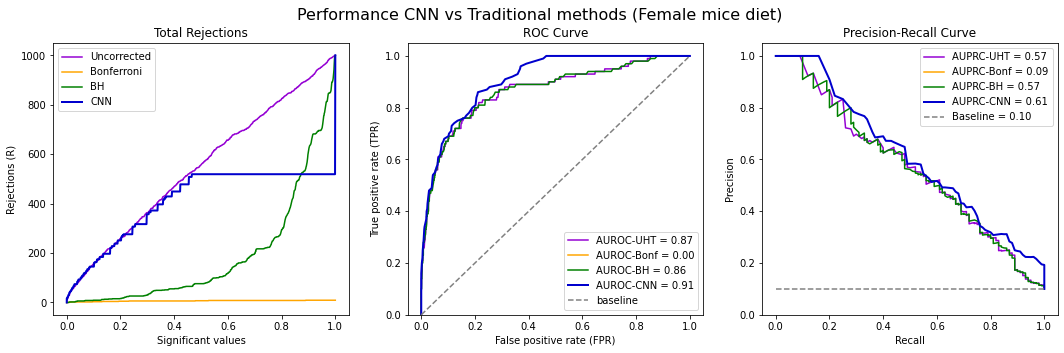

In [ ]:
# Plot function
baseline_pr = np.sum(code_nullHypothesis.ravel())/len(code_nullHypothesis.ravel())
plot_performance_metrics(v_grid = grid_significant,
                 out_sig_grid = out_stats_MHT,
                 baseline_pr = baseline_pr,
                 title = 'Performance CNN vs Traditional methods (Female mice diet)', 
                 out_CNN = out_test_CNN,
                 fig_save = 'fig2_10_comparison_CNN.png')

In [ ]:
from google.colab import files
files.download("fig2_10_comparison_CNN.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## References

# References <a name="Reference"></a> 

[0] Aghaebrahimian, A., & Cieliebak, M. (2019). Towards Integration of Statistical Hypothesis Tests into Deep Neural Networks. 	arXiv:1906.06550. [https://arxiv.org/abs/1906.06550](https://arxiv.org/abs/1906.06550)

[1] Benjamini, Y., & Hochberg, Y., (1995). Controlling the False Discovery Rate: A practical and Powerful Approach to Multiple Testing. Journal or the Royal Statistical society. [https://www.jstor.org/stable/2346101](https://www.jstor.org/stable/2346101)

[2] Efron, B., & Hastie, T., (2016). Computer Age Statistical Inference: Algorithms, Evidence and Data Science. Cambridge University Press. [https://web.stanford.edu/~hastie/CASI/](https://web.stanford.edu/~hastie/CASI/)

[3] Irizarry, R. A., & Love, M.I., (2021). Data Analysis for the Life Sciences. Leanpub. (https://leanpub.com/dataanalysisforthelifesciences)

[4] Puolivali, T., Palva, S., & Palva, J. M, (2020). Influence of multiple hypothesis testing on repreducibility in neuroimaging research: A simulation study and Python-Based software. Journal of Neuroscience Methods. [https://www.sciencedirect.com/science/article/abs/pii/S0165027020300765](https://www.sciencedirect.com/science/article/abs/pii/S0165027020300765)

[5] Sellke, T., Bayarri M.J., & Berger J.O, (2001). Calibration of p-values for testing Precise Null Hypothesis. The American Statistician Vol 55, No. 1. [https://www.jstor.org/stable/2685531](https://www.jstor.org/stable/2685531)

[6] Brodersen, K.H., Ong, C.S., Stephan, K.E., Buhmann, J.M. (2010). The balanced accuracy and its posterior distribution. Proceedings of the 20th International Conference on Pattern Recognition, 3121-24. [https://ieeexplore.ieee.org/document/5597285](https://ieeexplore.ieee.org/document/5597285)